# Определение возраста покупателей

Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [29]:
labels.shape

(7591, 2)

Фотографий не так много и для улучшения качества модели, как минимум выборку нужно обогатить зеркальными дублями при обучении модели.

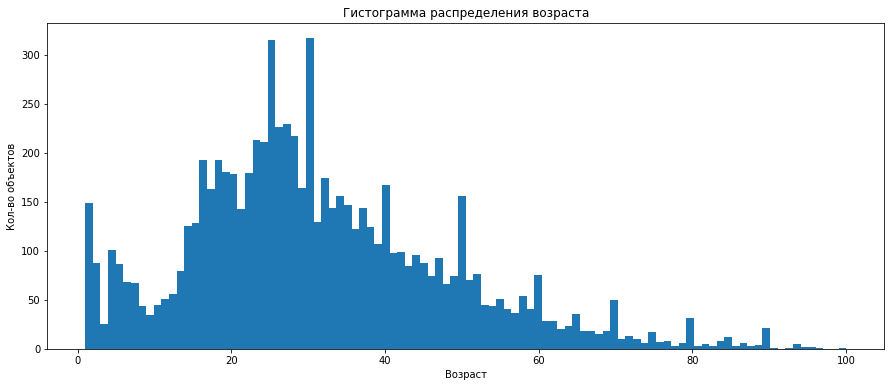

In [53]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.hist(labels.iloc[:,1], bins=100)
ax.set_title('Гистограмма распределения возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Кол-во объектов')
plt.show();

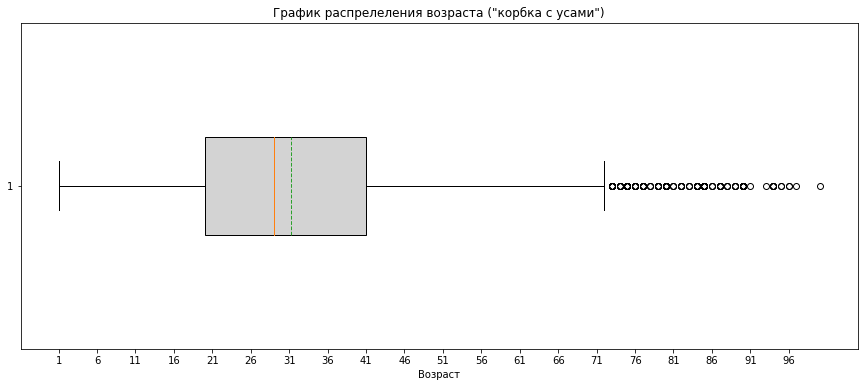

In [83]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.boxplot(labels.iloc[:,1],
           vert=False,
           patch_artist=True,
           showmeans = True,
           meanline = True,
           boxprops = dict(facecolor = "lightgrey"),
           widths=0.3, )

ax.set_title('График распрелеления возраста ("корбка с усами")')
ax.set_xlabel('Возраст')

plt.xticks([i for i in range(1,100,5)])
plt.show();

In [7]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


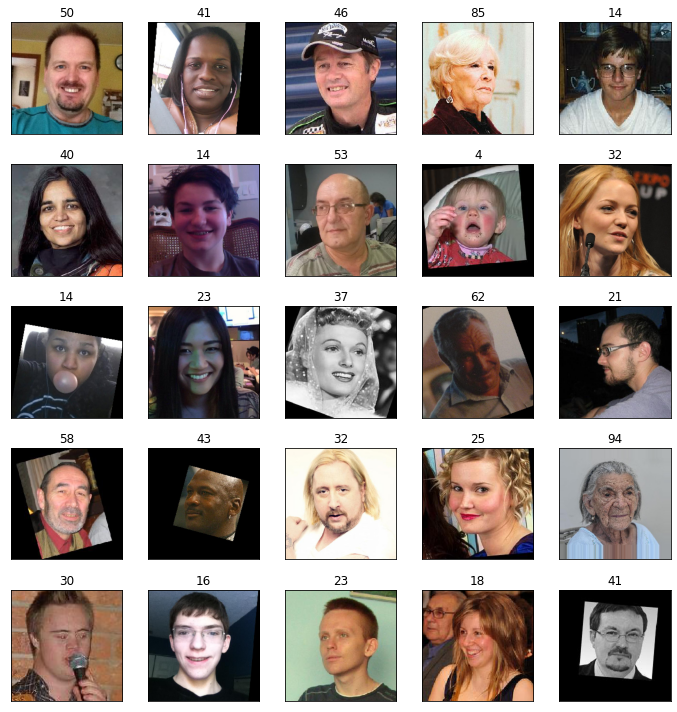

In [8]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод:

1. Выборка состоит из 7591 цветного изображения разрешением 224 на 224 пикселя.
2. Средний возраст людей на фотографиях - 31 год.
3. Боксплот показывает, что фотографии людей возрастом больше 72 лет находятся в выбросе. Заранее рассчитываем на ошибку для старшего поколения.
4. При выводе случайных изображений обнаружил изображения:
    - цветные и черно-белые
    - растянуты, сжатые и повернутые
    - изображения в полный рост
    - изображения низкого качества
    - на фотографиях присутствуют люди в головных уборах и очках
    - групповые снимки
    - некоторые изображения имеют артефакты и неравномерное освещение
    - различные ракурсы съемки
    - изображения без людей
    - на большинстве изображений лицо находится по центру кадра
5. Чтобы улучшить качество предсказания можно:
    - сделать часть фотографий обучающей выборки черно-белой
    - обрезать края изображений чтобы избавится от артефактов, затемненных краев и обстановки
    - обогатить выборку зеркальными отражениями

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps

Epoch 1/10

2023-08-03 19:19:10.378620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-08-03 19:19:10.673598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 52s - loss: 216.6534 - mae: 10.5679 - val_loss: 454.4637 - val_mae: 16.1006

Epoch 2/10

356/356 - 57s - loss: 86.6995 - mae: 7.0162 - val_loss: 103.9524 - val_mae: 7.7107

Epoch 3/10

356/356 - 49s - loss: 58.1769 - mae: 5.8434 - val_loss: 118.4681 - val_mae: 8.7022

Epoch 4/10

356/356 - 48s - loss: 42.8088 - mae: 5.0459 - val_loss: 78.8072 - val_mae: 6.5423

Epoch 5/10

356/356 - 57s - loss: 31.1652 - mae: 4.2921 - val_loss: 72.8957 - val_mae: 6.4177

Epoch 6/10

356/356 - 44s - loss: 23.6665 - mae: 3.7588 - val_loss: 78.9164 - val_mae: 6.6390

Epoch 7/10

356/356 - 52s - loss: 17.9623 - mae: 3.2504 - val_loss: 68.8389 - val_mae: 6.0959

Epoch 8/10

356/356 - 56s - loss: 15.6348 - mae: 3.0235 - val_loss: 64.5814 - val_mae: 6.0300

Epoch 9/10

356/356 - 45s - loss: 15.4404 - mae: 2.9701 - val_loss: 128.2926 - val_mae: 8.3020

Epoch 10/10

356/356 - 56s - loss: 15.0550 - mae: 2.9553 - val_loss: 61.3013 - val_mae: 5.8784

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 11s - loss: 61.3013 - mae: 5.8784

Test MAE: 5.8784


```

## Анализ обученной модели

- Модель обучена на 10 эпохах на ResNet50 с использованием алгоритма оптимизации Adam(lr=0.0001);
- 5.8784 - ошибка в определении возраста - это хороший показатель, так как для категорий пользователей погрешность в 6 лет не так критична (целевой показатель "менее 7" достигнут);
- На трейне модель переобучилась, mae = 2.9553;
- В выборке больше людей в возрасте от 20 до 42 лет. Если количество людей по категориям возрастов будет сопоставимой (в каждой возрастной группе по годам), вероятно качество модели возможно будет улучшить;